In [2]:
import pandas as pd
import requests, bs4
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 15, 10

In [3]:
def tag_to_row(x):
    tds = x.find_all('td')
    try:
        event = tds[0].contents[2].text
        date = pd.Timestamp(tds[0].contents[-1])
        return([date, event] + map(lambda w:w.text, tds[1:]))
    except:
        return []

The following function can be used to pull up a wrestler's record of matches, and compute a running score of #wins - #losses. You can use the <code>include_wwe_live</code> keyword to specify whether to include <code>"only"</code> WWE Live events (i.e. house shows) or to include <code>"none"</code> of them, or to include them. The default behaviour is to include them.

In [4]:
def get_record(gimmick_name, include_wwe_live = 'yep'):
    if gimmick_name.lower() == 'kane':
        results_url = 'http://www.profightdb.com/wrestlers/kane-197.html?res=2000&sort=rev'
    else:
        search_url = 'http://www.profightdb.com/search.html?search-term=%s&submit=search' % gimmick_name.lower().replace(' ','+')
        soup = bs4.BeautifulSoup(requests.get(search_url).text)
        results_url = 'http://profightdb.com' + soup.find('a',text=gimmick_name).get('href') + '?res=2000&sort=rev'
    results_text = requests.get(results_url).text
    l = bs4.BeautifulSoup(results_text[results_text.find('title(s)'):]).find_all('tr')[:-1]
    df = pd.DataFrame(map(tag_to_row,l), columns=['date','event','winner','outcome','loser','stip','prize']).dropna(how='all').set_index('date')
    if include_wwe_live == 'only':
        df = df[df.event.str.contains('WWE Live')]
    elif include_wwe_live == 'none':
        df = df[~df.event.str.contains('WWE Live')]
    df['won'] = ((df.winner.str.contains(gimmick_name)) & df.outcome.str.contains('def.')).apply(int)
    df['lost'] = ((df.loser.str.contains(gimmick_name)) & df.outcome.str.contains('def.')).apply(int)
    df['score'] = (df.won - df.lost).cumsum()
    return(df)

##  Example usage

In [5]:
df = get_record('Jack Swagger', include_wwe_live='only')

In [6]:
df.head()

,event,winner,outcome,loser,stip,prize,won,lost,score
date,,,,,,,,,
2010-03-10,WWE WWE Live,John Cena & Shawn Michaels & Triple H,def. (pin),Batista & Jack Swagger & Sheamus,6-person tag,,0,1,-1
2012-07-14,WWE WWE Live,Kofi Kingston (c) & R-Truth (c),def. (pin),Dolph Ziggler & Jack Swagger,,WWE Tag Team Championship,0,1,-2
2012-07-20,WWE WWE Live (Raw),Brodus Clay,def. (pin),Jack Swagger,,,0,1,-3
2012-07-21,WWE WWE Live (Raw),Brodus Clay,def. (pin),Jack Swagger,,,0,1,-4
2012-07-22,WWE WWE Live (Raw),Brodus Clay,def. (pin),Jack Swagger,,,0,1,-5


In [7]:
df2 = get_record('John Cena')

In [8]:
df2.tail()

,event,winner,outcome,loser,stip,prize,won,lost,score
date,,,,,,,,,
2015-10-02,WWE WWE Live,John Cena (c),def. (pin),Seth Rollins,,WWE United States Championship,1,0,553
2015-10-03,WWE WWE Network Special - Live From MSG,John Cena (c),def. (pin),Seth Rollins,steel cage,WWE United States Championship,1,0,554
2015-10-04,WWE WWE Live,John Cena (c),def. (pin),Seth Rollins,street fight,WWE United States Championship,1,0,555
2015-10-05,WWE Monday Night Raw,John Cena (c),def. (pin),Big E,open challenge,WWE United States Championship,1,0,556
2015-10-12,WWE Monday Night Raw,John Cena (c),def. (pin),Dolph Ziggler,open challenge,WWE United States Championship,1,0,557


In [9]:
df3 = get_record('John Cena', include_wwe_live='none')

In [10]:
df3.tail()

,event,winner,outcome,loser,stip,prize,won,lost,score
date,,,,,,,,,
2015-09-28,WWE Monday Night Raw,John Cena (c),def. (DQ),Xavier Woods,open challenge,WWE United States Championship,1,0,304
2015-09-28,WWE Monday Night Raw,Big E & Kofi Kingston & Xavier Woods,def. (pin),Bubba Ray Dudley & D-Von Dudley & John Cena,6-person tag,,0,1,303
2015-10-03,WWE WWE Network Special - Live From MSG,John Cena (c),def. (pin),Seth Rollins,steel cage,WWE United States Championship,1,0,304
2015-10-05,WWE Monday Night Raw,John Cena (c),def. (pin),Big E,open challenge,WWE United States Championship,1,0,305
2015-10-12,WWE Monday Night Raw,John Cena (c),def. (pin),Dolph Ziggler,open challenge,WWE United States Championship,1,0,306


The next function can be used to generate those graphs of (#wins - #losses) over time.

In [11]:
def plot_records(*gimmick_names, **kwargs):
    live_condition = None
    if 'include_wwe_live' in kwargs:
        live_condition = kwargs['include_wwe_live']
        scores = {x:get_record(x, include_wwe_live=live_condition).score for x in gimmick_names}
    else:
        scores = {x:get_record(x).score for x in gimmick_names}
    for x in gimmick_names:
        scores[x].plot(label=x)
    if live_condition == 'only':
        plt.title('Wins minus losses - WWE Live events only')
    elif live_condition == 'none':
        plt.title('Wins minus losses - WWE Live events excluded')
    else:
        plt.title('Wins minus losses - WWE Live events included')        
    plt.legend(loc=2)

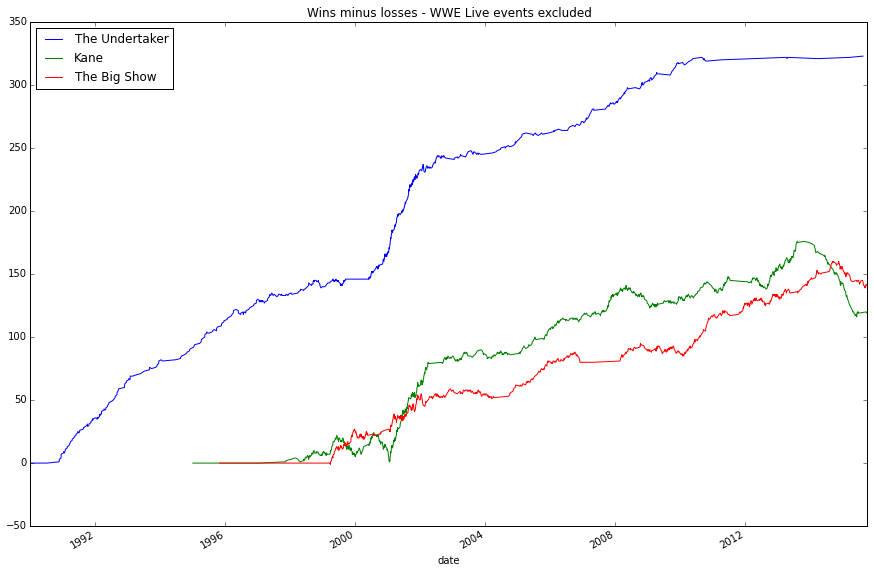

In [19]:
plot_records('The Undertaker','Kane', 'The Big Show', include_wwe_live='none')

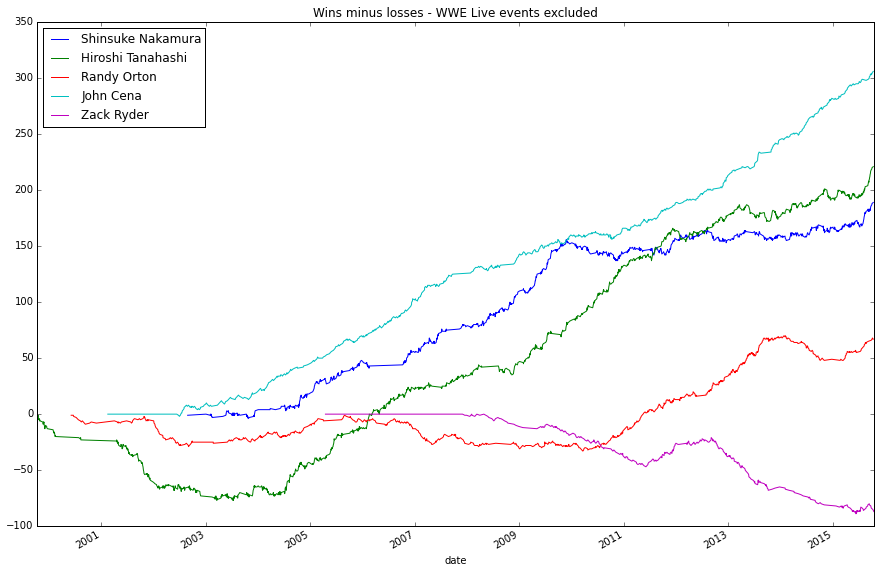

In [26]:
plot_records('Shinsuke Nakamura','Hiroshi Tanahashi','Randy Orton','John Cena','Zack Ryder', include_wwe_live='none')

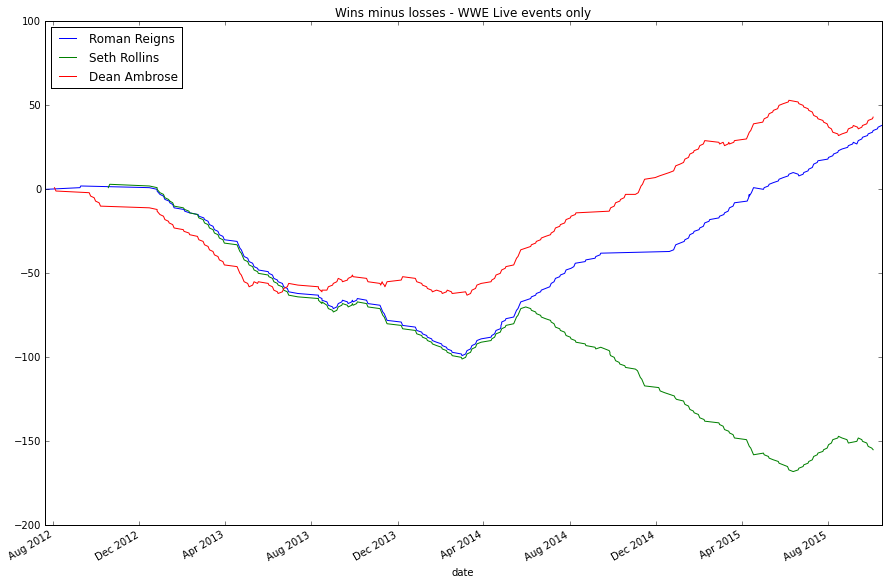

In [15]:
plot_records('Roman Reigns','Seth Rollins','Dean Ambrose', include_wwe_live='only')

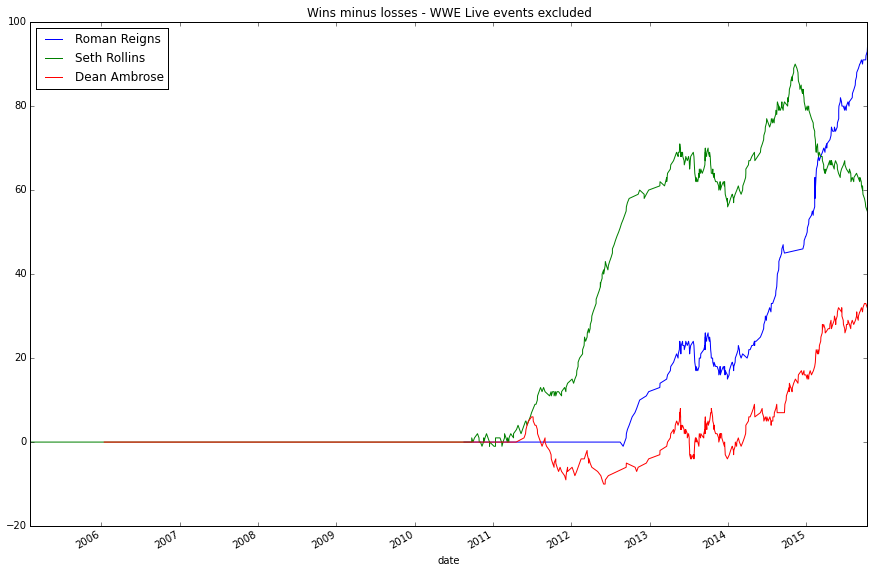

In [16]:
plot_records('Roman Reigns','Seth Rollins','Dean Ambrose', include_wwe_live='none')

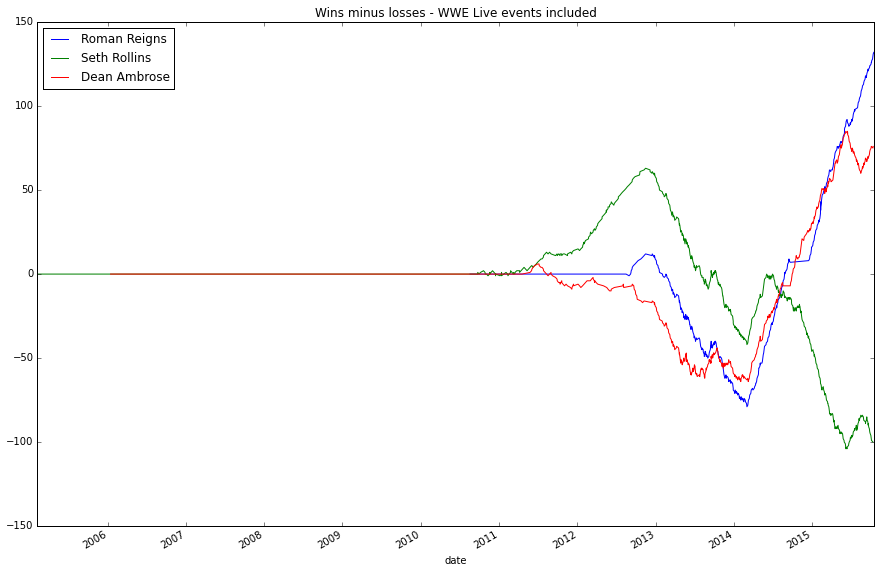

In [17]:
plot_records('Roman Reigns','Seth Rollins','Dean Ambrose')

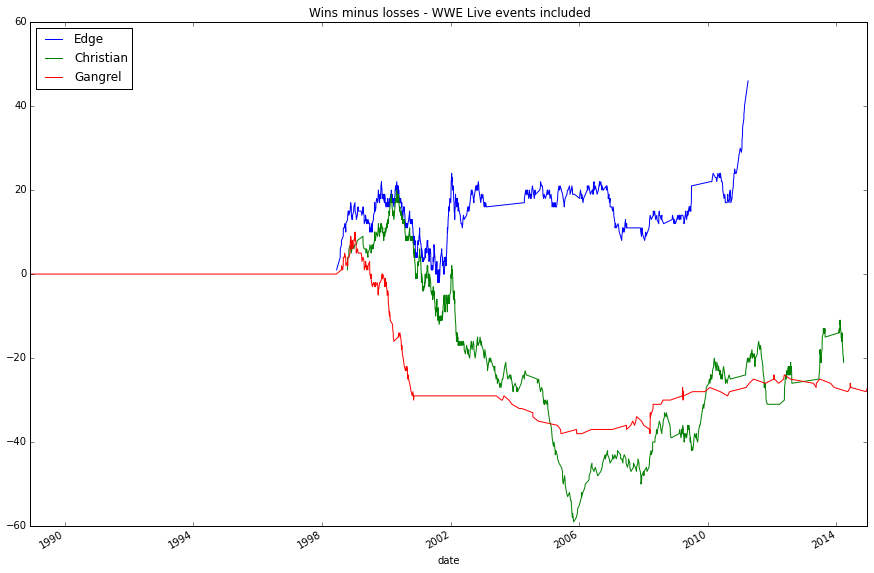

In [21]:
plot_records('Edge','Christian','Gangrel')

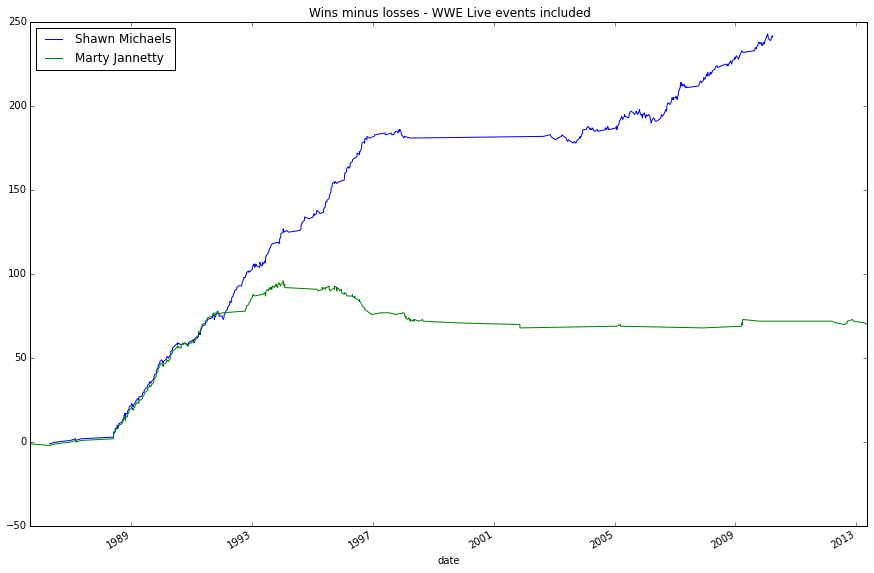

In [22]:
plot_records('Shawn Michaels','Marty Jannetty')